## Sequence models
<a href="https://d2l.ai/chapter_recurrent-neural-networks/sequence.html#statistical-tools">Lecture</a>

---
Predicting sequential data is challenging. Not only because we need to work with text data, but the audience can spice
things up. Below we can see the common behaviors that psychologists have notices:
* Anchoring: being bias towards a specific award. If the movie wins an Oscar, the ratings
go up drastically until people forget about it.
* Hedonic adaptation: quick adaptation to accept modified version (doesn't matter if it's for the better or worse)
* Seasonality: watching specific genre at specific time of the year
* Cancel culture: refusing to watch something because a member of the set misbehaves


### Terminology
- interpolation: latter prediction
- extrapolation: former prediction
- autoregressive model: training regression on itself <br>
Input: instead of $x_{t-1}, ..., x_{1}$, apply $x_{t-1}, ..., x_{t-\tau}$ observations, where $\tau$ = timespan of specific length

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### Training
We begin by generating some data. To keep things simple we generate our sequence data by using a sine function with some additive noise for time steps  1,2,...,1000.

The first example is going to be a simple MLP with two FC layers, ReLU activation function, and MSE loss.

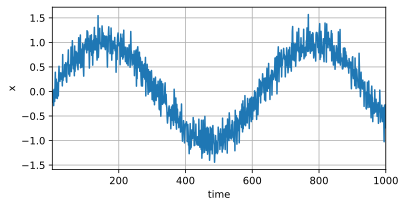

In [19]:
# create 1000 values
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
# add some noise
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

Next, we need to transform them into features and targets. Thus, we will map them to:
* $y_t = x_t$
* $x_t = [x_{t-\tau}, ..., x_{t-1}]$ <br>
When we don't know the first instances of $\tau$, we can either subtract it from t or add paddings with zeros.

In [9]:
# create first 600 feature-label pairs
tau = 4
features = torch.zeros((T - tau, tau))

for idx in range(tau):
    features[:, idx] = x[idx:T - tau + idx]

labels = x[tau:].reshape((-1, 1))
print(f'Features shape: {features.shape}, Labels shape: {labels.shape}')

# create batches and train loader
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

Features shape: torch.Size([996, 4]), Labels shape: torch.Size([996, 1])


In [8]:
def init_weights(m):
    """
    Thus function initializes the weights for the model
        :param m: Model to use
    """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)


def get_net():
    """
    This function instantiates a new MLP model
        :return: MLP model
    """
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# create MSE loss
loss = nn.MSELoss()


In [11]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'Epoch: {epoch + 1}, loss: {d2l.evaluate_loss(net, train_iter, loss)}')


net = get_net()
train(net, train_iter, loss, 10, 0.01)

<ipython-input-8-5f6664992771>:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


Epoch: 1, loss: 0.05889416378187506
Epoch: 2, loss: 0.05528852524922082
Epoch: 3, loss: 0.05485411880439833
Epoch: 4, loss: 0.05332567640825322
Epoch: 5, loss: 0.05252977191029411
Epoch: 6, loss: 0.05297373154347664
Epoch: 7, loss: 0.051563137701075325
Epoch: 8, loss: 0.05259973923430631
Epoch: 9, loss: 0.051200255457507934
Epoch: 10, loss: 0.050905891890196425


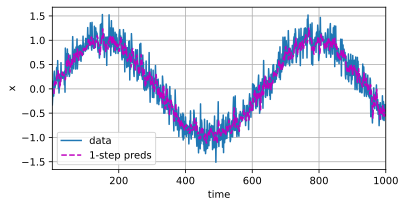

In [13]:
# predict
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3)
)


#### Differences in step predictions
We see that there's a disconnection in some cases, so it's logical to use multistep-ahead predictions. Let's look at it,
and instances where we increase it further.


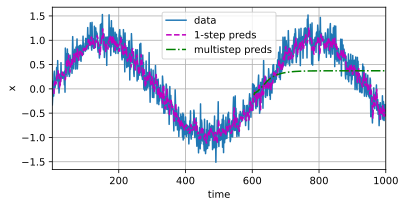

In [15]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for idx in range(n_train + tau, T):
    multistep_preds[idx] = net(multistep_preds[idx - tau:idx].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

As we see above, the multistep predictions fail drastically in comparison to 1-step ones. The reason behind that
is the errors keep building up on each other. It's a common phenomenon where we have $\epsilon_1=\hat\epsilon$, which
is followed by $\epsilon_2=\hat\epsilon + c\epsilon_1$. So it keeps increasing each time.  For instance, weather
forecasts for the next 24 hours tend to be pretty accurate but beyond that the accuracy declines rapidly.

That leads to a question: "What will happen if we keep increasing the steps?"

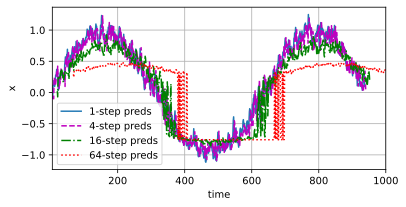

In [17]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))